In [2]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.stats import run_chisq

In [4]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2019-05-08 
Git hash: 9ddd7503faed72e31cd15a0f452f5a9a6569a65d


In [23]:
clusters = (
    pd.read_parquet('../output/scrnaseq-wf/clusters.parquet')
    .assign(rep=lambda df: df.index.str.extract('(rep\d)', expand=False))
    .assign(cluster=lambda df: pd.Categorical(df.cluster.map(nbconfig.short_cluster_annot), ordered=True, categories=nbconfig.short_cluster_order + ['UNK']))
)

In [25]:
number_of_cells = clusters.groupby(['cluster', 'rep']).size().rename('number_of_cells').to_frame()
number_of_cells

number_of_cells
cluster rep                  
SP      rep1              111
        rep2              376
        rep3              880
E1º     rep1              134
        rep2              417
        rep3              867
M1º     rep1              257
        rep2              338
        rep3             1056
L1º     rep1              519
        rep2              139
        rep3             1356
EC      rep1              256
        rep2              372
        rep3              745
MC      rep1              631
        rep2              314
        rep3              799
LC      rep1              305
        rep2              433
        rep3              646
TE      rep1              185
        rep2              164
        rep3              597
PC      rep1              123
        rep2               81
        rep3              503
UNK     rep1              289
        rep2              366
        rep3              551

In [158]:
ct = number_of_cells.unstack().T
ct.index = ct.index.droplevel(0)
res = run_chisq(ct.T).loc[(slice(None), ['adj std residual', 'flag_sig']), :]

summary = {'flag_sig_bias': {}}
for clus, dd in res.groupby('cluster'):
    dd.index = dd.index.droplevel(0)
    for rep, ddd in dd.T.iterrows():
        summary['flag_sig_bias'][(clus, rep)] = 0
        if ddd.flag_sig:
            if ddd['adj std residual'] < 0:
                summary['flag_sig_bias'][(clus, rep)] = -1
            elif ddd['adj std residual'] > 0:
                summary['flag_sig_bias'][(clus, rep)] = 1

flag_sig_bias = (
    pd.DataFrame(summary)
    .rename_axis(['cluster', 'rep'])
    .reset_index()
    .assign(cluster=lambda df: pd.Categorical(df.cluster, ordered=True, categories=nbconfig.short_cluster_order + ['UNK']))
    .set_index(['cluster', 'rep'])
)
flag_sig_bias

𝛘^2: 1,084.6553, p-value: 0.0000, df: 18


flag_sig_bias
cluster rep                
E1º     rep1             -1
        rep2              1
        rep3              1
EC      rep1              0
        rep2              1
        rep3             -1
L1º     rep1              1
        rep2             -1
        rep3              1
LC      rep1              0
        rep2              1
        rep3             -1
M1º     rep1             -1
        rep2              0
        rep3              1
MC      rep1              1
        rep2             -1
        rep3             -1
PC      rep1              0
        rep2             -1
        rep3              1
SP      rep1             -1
        rep2              1
        rep3              1
TE      rep1              0
        rep2             -1
        rep3              1
UNK     rep1              1
        rep2              1
        rep3             -1

In [169]:
summary_stats = (
    pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster_w_rep.parquet')
    .assign(cluster=lambda df: pd.Categorical(df.cluster.map(nbconfig.short_cluster_annot), ordered=True, categories=nbconfig.short_cluster_order + ['UNK']))
    .groupby(['cluster', 'rep']).describe()
)
summary_stats.columns = summary_stats.columns.droplevel(0)
summary_stats = summary_stats.drop('count', axis=1)
summary_stats

mean          std  min   25%    50%     75%       max
cluster rep                                                               
SP      rep1   133.888022   759.371249  0.0   0.0    7.0    61.0   44192.0
        rep2   503.476651  2593.675284  0.0   2.0   47.0   256.0   76752.0
        rep3   456.915377  2262.111287  0.0   2.0   48.0   252.0   49041.0
E1º     rep1    35.150801   154.696843  0.0   0.0    5.0    26.0    7802.0
        rep2  1365.853413  3975.771503  0.0  13.0  149.0  1029.0   92221.0
        rep3   717.664686  2093.816794  0.0   8.0   89.0   571.0   57823.0
M1º     rep1    83.157364   395.585790  0.0   0.0    5.0    36.0   16080.0
        rep2   721.255319  2606.881117  0.0   5.0   46.0   388.0   73366.0
        rep3   496.195496  1807.818917  0.0   4.0   35.0   272.0   48064.0
L1º     rep1    33.548218   249.837789  0.0   0.0    2.0    14.0   14652.0
        rep2   102.135880   342.707992  0.0   1.0    9.0    65.0    9078.0
        rep3   169.381114   720.839761  0.0   1.0   16.0   108.0   36231.0
EC      rep1   190.830133  1771.493379  0.0   0.0    4.0    46.0  165104.0
        rep2   192.399489  1222.818914  0.0   1.0   15.0    71.0   62155.0
        rep3   212.554642  1250.268802  0.0   1.0   23.0    96.0   50122.0
MC      rep1   112.455996  1240.835967  0.0   0.0    6.0    32.0  118225.0
        rep2   108.983973   708.123919  0.0   1.0   10.0    50.0   42790.0
        rep3   131.002141   754.122830  0.0   1.0   15.0    70.0   31532.0
LC      rep1    94.816179   853.002635  0.0   0.0    6.0    29.0   73400.0
        rep2   152.413305  1034.381982  0.0   1.0   13.0    62.0   58130.0
        rep3   123.027632   715.036959  0.0   1.0   14.0    65.0   28677.0
TE      rep1   102.235631  1126.477204  0.0   0.0    2.0    30.0  114751.0
        rep2    71.525145   559.225917  0.0   0.0    6.0    27.0   32662.0
        rep3   102.942042   623.132239  0.0   1.0   13.0    55.0   25331.0
PC      rep1    76.186170   696.034381  0.0   0.0    2.0    22.0   65363.0
        rep2    37.709312   270.971360  0.0   0.0    3.0    15.0   17830.0
        rep3   153.479345   968.628326  0.0   1.0   17.0    75.0   52146.0
UNK     rep1    35.073950   461.777221  0.0   0.0    1.0     7.0   63284.0
        rep2   598.390854  3650.894590  0.0   1.0    7.0    57.0  193014.0
        rep3   294.616929  1647.590118  0.0   1.0    9.0    55.0   89411.0

In [170]:
df = number_of_cells.join(flag_sig_bias).join(summary_stats)

In [171]:
df

number_of_cells  flag_sig_bias         mean          std  min  \
cluster rep                                                                   
SP      rep1              111             -1   133.888022   759.371249  0.0   
        rep2              376              1   503.476651  2593.675284  0.0   
        rep3              880              1   456.915377  2262.111287  0.0   
E1º     rep1              134             -1    35.150801   154.696843  0.0   
        rep2              417              1  1365.853413  3975.771503  0.0   
        rep3              867              1   717.664686  2093.816794  0.0   
M1º     rep1              257             -1    83.157364   395.585790  0.0   
        rep2              338              0   721.255319  2606.881117  0.0   
        rep3             1056              1   496.195496  1807.818917  0.0   
L1º     rep1              519              1    33.548218   249.837789  0.0   
        rep2              139             -1   102.135880   342.707992  0.0   
        rep3             1356              1   169.381114   720.839761  0.0   
EC      rep1              256              0   190.830133  1771.493379  0.0   
        rep2              372              1   192.399489  1222.818914  0.0   
        rep3              745             -1   212.554642  1250.268802  0.0   
MC      rep1              631              1   112.455996  1240.835967  0.0   
        rep2              314             -1   108.983973   708.123919  0.0   
        rep3              799             -1   131.002141   754.122830  0.0   
LC      rep1              305              0    94.816179   853.002635  0.0   
        rep2              433              1   152.413305  1034.381982  0.0   
        rep3              646             -1   123.027632   715.036959  0.0   
TE      rep1              185              0   102.235631  1126.477204  0.0   
        rep2              164             -1    71.525145   559.225917  0.0   
        rep3              597              1   102.942042   623.132239  0.0   
PC      rep1              123              0    76.186170   696.034381  0.0   
        rep2               81             -1    37.709312   270.971360  0.0   
        rep3              503              1   153.479345   968.628326  0.0   
UNK     rep1              289              1    35.073950   461.777221  0.0   
        rep2              366              1   598.390854  3650.894590  0.0   
        rep3              551             -1   294.616929  1647.590118  0.0   

               25%    50%     75%       max  
cluster rep                                  
SP      rep1   0.0    7.0    61.0   44192.0  
        rep2   2.0   47.0   256.0   76752.0  
        rep3   2.0   48.0   252.0   49041.0  
E1º     rep1   0.0    5.0    26.0    7802.0  
        rep2  13.0  149.0  1029.0   92221.0  
        rep3   8.0   89.0   571.0   57823.0  
M1º     rep1   0.0    5.0    36.0   16080.0  
        rep2   5.0   46.0   388.0   73366.0  
        rep3   4.0   35.0   272.0   48064.0  
L1º     rep1   0.0    2.0    14.0   14652.0  
        rep2   1.0    9.0    65.0    9078.0  
        rep3   1.0   16.0   108.0   36231.0  
EC      rep1   0.0    4.0    46.0  165104.0  
        rep2   1.0   15.0    71.0   62155.0  
        rep3   1.0   23.0    96.0   50122.0  
MC      rep1   0.0    6.0    32.0  118225.0  
        rep2   1.0   10.0    50.0   42790.0  
        rep3   1.0   15.0    70.0   31532.0  
LC      rep1   0.0    6.0    29.0   73400.0  
        rep2   1.0   13.0    62.0   58130.0  
        rep3   1.0   14.0    65.0   28677.0  
TE      rep1   0.0    2.0    30.0  114751.0  
        rep2   0.0    6.0    27.0   32662.0  
        rep3   1.0   13.0    55.0   25331.0  
PC      rep1   0.0    2.0    22.0   65363.0  
        rep2   0.0    3.0    15.0   17830.0  
        rep3   1.0   17.0    75.0   52146.0  
UNK     rep1   0.0    1.0     7.0   63284.0  
        rep2   1.0    7.0    57.0  193014.0  
        rep3   1.0    9.0    55.0   89411.0

In [196]:
def _calc_prop(x):
    return x / x.sum()
    
plot_dat = (
    df.groupby('cluster').number_of_cells.apply(_calc).reset_index()
    .rename(columns={'number_of_cells': 'proportion_of_cells'})
    .set_index(['cluster', 'rep'])
    .unstack()
)
plot_dat.columns = plot_dat.columns.droplevel(0)

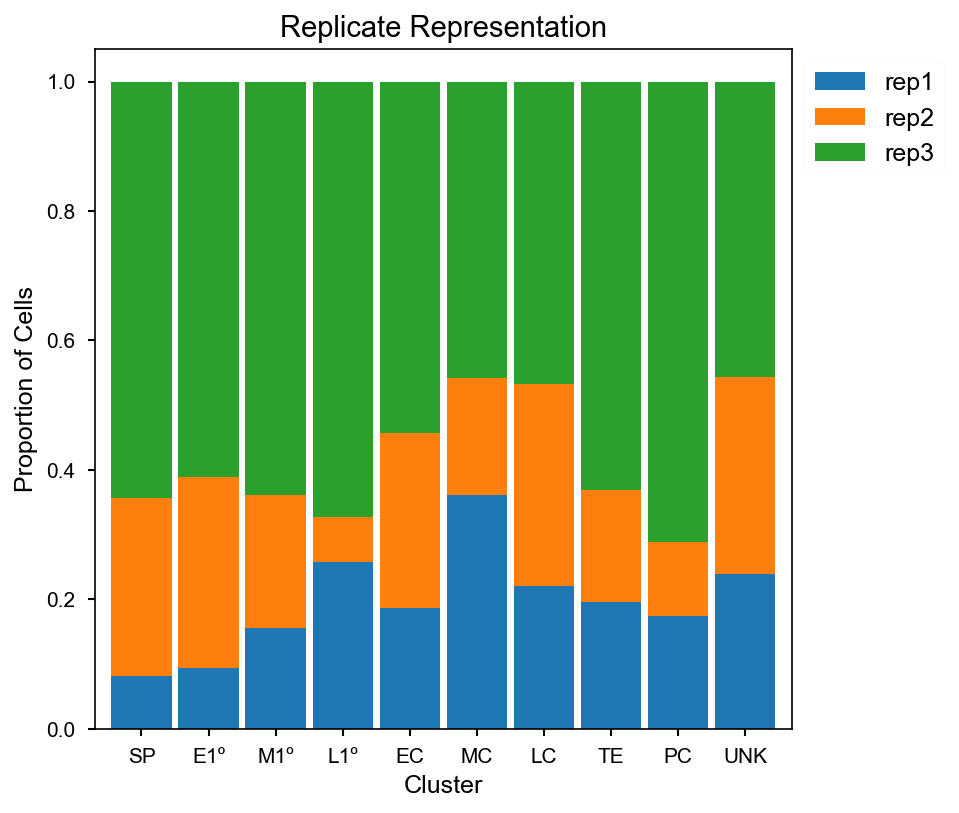

In [205]:
ax = plot_dat.plot(kind='bar', stacked=True, width=.9)
ax.set(xlabel='Cluster', ylabel='Proportion of Cells', title='Replicate Representation')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(loc='upper left', bbox_to_anchor=[1, 1]);

In [206]:
df

number_of_cells  flag_sig_bias         mean          std  min  \
cluster rep                                                                   
SP      rep1              111             -1   133.888022   759.371249  0.0   
        rep2              376              1   503.476651  2593.675284  0.0   
        rep3              880              1   456.915377  2262.111287  0.0   
E1º     rep1              134             -1    35.150801   154.696843  0.0   
        rep2              417              1  1365.853413  3975.771503  0.0   
        rep3              867              1   717.664686  2093.816794  0.0   
M1º     rep1              257             -1    83.157364   395.585790  0.0   
        rep2              338              0   721.255319  2606.881117  0.0   
        rep3             1056              1   496.195496  1807.818917  0.0   
L1º     rep1              519              1    33.548218   249.837789  0.0   
        rep2              139             -1   102.135880   342.707992  0.0   
        rep3             1356              1   169.381114   720.839761  0.0   
EC      rep1              256              0   190.830133  1771.493379  0.0   
        rep2              372              1   192.399489  1222.818914  0.0   
        rep3              745             -1   212.554642  1250.268802  0.0   
MC      rep1              631              1   112.455996  1240.835967  0.0   
        rep2              314             -1   108.983973   708.123919  0.0   
        rep3              799             -1   131.002141   754.122830  0.0   
LC      rep1              305              0    94.816179   853.002635  0.0   
        rep2              433              1   152.413305  1034.381982  0.0   
        rep3              646             -1   123.027632   715.036959  0.0   
TE      rep1              185              0   102.235631  1126.477204  0.0   
        rep2              164             -1    71.525145   559.225917  0.0   
        rep3              597              1   102.942042   623.132239  0.0   
PC      rep1              123              0    76.186170   696.034381  0.0   
        rep2               81             -1    37.709312   270.971360  0.0   
        rep3              503              1   153.479345   968.628326  0.0   
UNK     rep1              289              1    35.073950   461.777221  0.0   
        rep2              366              1   598.390854  3650.894590  0.0   
        rep3              551             -1   294.616929  1647.590118  0.0   

               25%    50%     75%       max  
cluster rep                                  
SP      rep1   0.0    7.0    61.0   44192.0  
        rep2   2.0   47.0   256.0   76752.0  
        rep3   2.0   48.0   252.0   49041.0  
E1º     rep1   0.0    5.0    26.0    7802.0  
        rep2  13.0  149.0  1029.0   92221.0  
        rep3   8.0   89.0   571.0   57823.0  
M1º     rep1   0.0    5.0    36.0   16080.0  
        rep2   5.0   46.0   388.0   73366.0  
        rep3   4.0   35.0   272.0   48064.0  
L1º     rep1   0.0    2.0    14.0   14652.0  
        rep2   1.0    9.0    65.0    9078.0  
        rep3   1.0   16.0   108.0   36231.0  
EC      rep1   0.0    4.0    46.0  165104.0  
        rep2   1.0   15.0    71.0   62155.0  
        rep3   1.0   23.0    96.0   50122.0  
MC      rep1   0.0    6.0    32.0  118225.0  
        rep2   1.0   10.0    50.0   42790.0  
        rep3   1.0   15.0    70.0   31532.0  
LC      rep1   0.0    6.0    29.0   73400.0  
        rep2   1.0   13.0    62.0   58130.0  
        rep3   1.0   14.0    65.0   28677.0  
TE      rep1   0.0    2.0    30.0  114751.0  
        rep2   0.0    6.0    27.0   32662.0  
        rep3   1.0   13.0    55.0   25331.0  
PC      rep1   0.0    2.0    22.0   65363.0  
        rep2   0.0    3.0    15.0   17830.0  
        rep3   1.0   17.0    75.0   52146.0  
UNK     rep1   0.0    1.0     7.0   63284.0  
        rep2   1.0    7.0    57.0  193014.0  
        rep3   1.0    9.0    55.0   89411.0